In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import pandas as pd
import cv2
import os

2025-10-01 06:59:58.992398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759301999.363731      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759301999.468752      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Reading the Data Images**

In [8]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    images = []
    target = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:  # tránh lỗi resize NoneType
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                target.append(class_num)
            except Exception as e:
                print("Lỗi ảnh:", e)
    return np.array(images), np.array(target)



# **Loading the Dataset**

In [41]:
# Gọi hàm
x_train, y_train = get_training_data('../input/chest-xray-pneumonia/chest_xray/train')
x_test, y_test   = get_training_data('../input/chest-xray-pneumonia/chest_xray/test')
x_val, y_val     = get_training_data('../input/chest-xray-pneumonia/chest_xray/val')

print(x_train.shape, y_train.shape)

(5216, 150, 150) (5216,)


# **Data Visualization & Preprocessing**

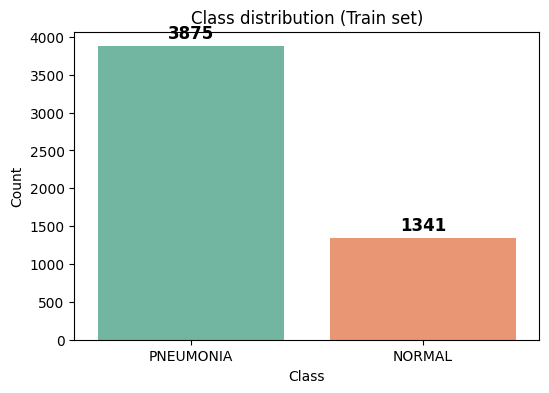

In [12]:
label_map = {0: 'PNEUMONIA', 1: 'NORMAL'}
l = [label_map[i] for i in y_train]

plt.figure(figsize=(6,4))
ax = sns.countplot(x=pd.Series(l), palette="Set2")

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height + 50),  
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.title("Class distribution (Train set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


Text(0.5, 1.0, 'NORMAL')

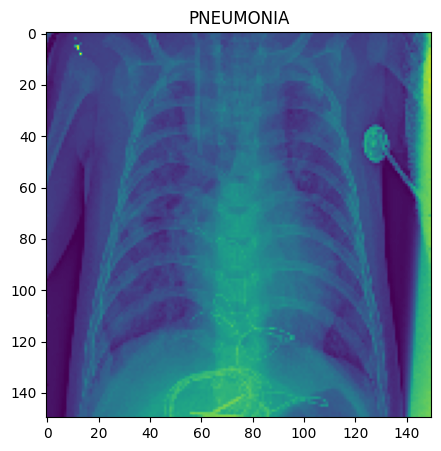

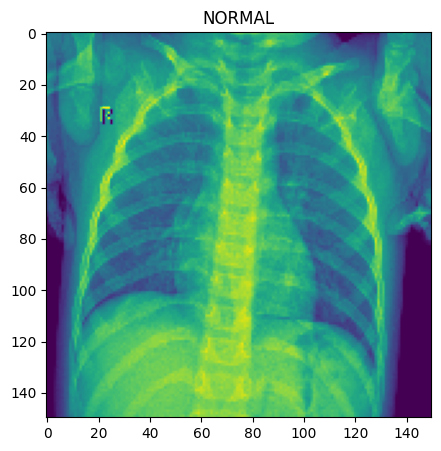

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(x_train[0], cmap='viridis')
plt.title(labels[y_train[0]])

plt.figure(figsize=(5,5))
plt.imshow(x_train[-1], cmap='viridis')
plt.title(labels[y_train[-1]])


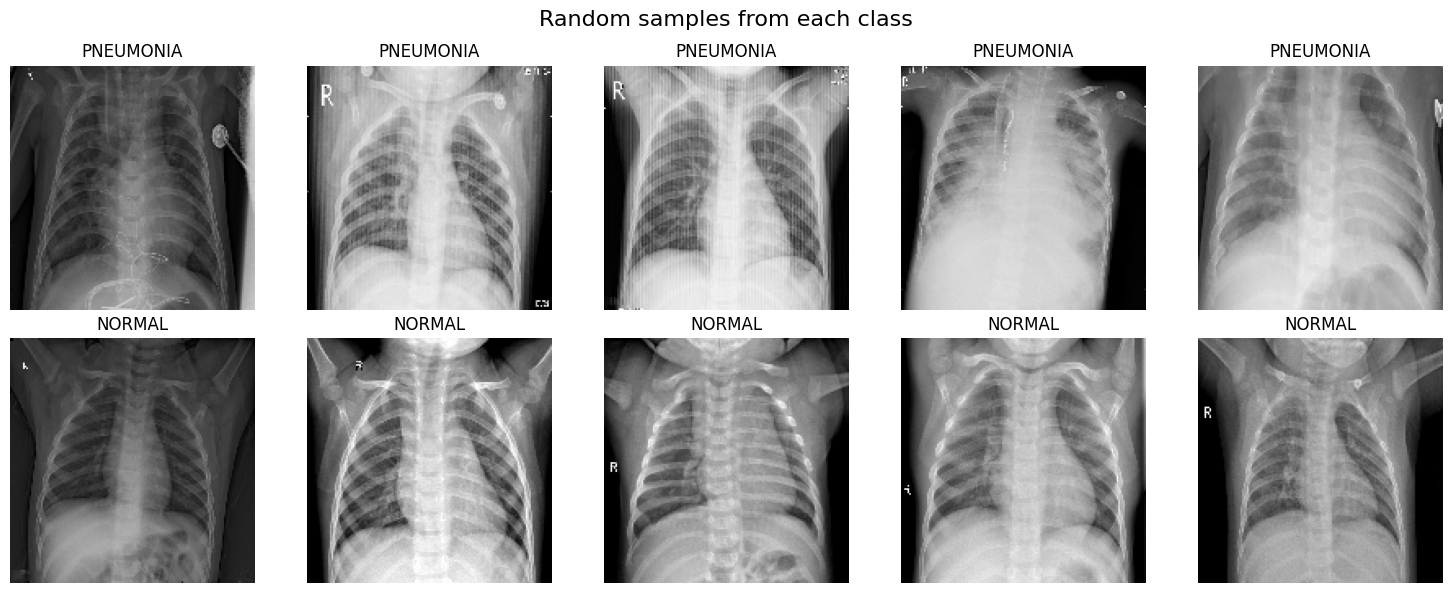

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# lấy 5 ảnh PNEUMONIA
pneumonia_samples = x_train[y_train == 0][:5]
for i, ax in enumerate(axes[0]):
    ax.imshow(pneumonia_samples[i], cmap='gray')
    ax.set_title("PNEUMONIA")
    ax.axis('off')

# lấy 5 ảnh NORMAL
normal_samples = x_train[y_train == 1][:5]
for i, ax in enumerate(axes[1]):
    ax.imshow(normal_samples[i], cmap='gray')
    ax.set_title("NORMAL")
    ax.axis('off')

plt.suptitle("Random samples from each class", fontsize=16)
plt.tight_layout()
plt.show()


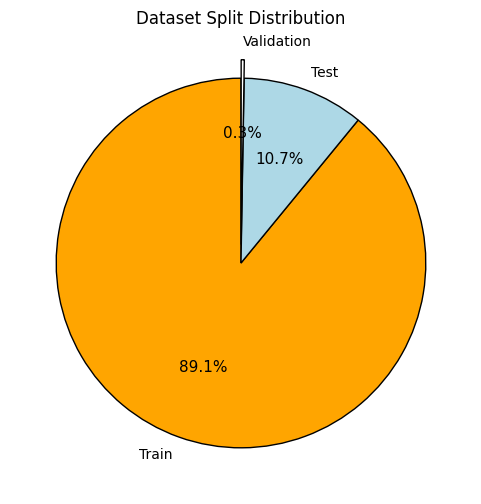

In [19]:
train_size = len(x_train)
test_size = len(x_test)
val_size = len(x_val)

# Dữ liệu
sizes = [train_size, test_size, val_size]
split_labels = ['Train', 'Test', 'Validation']
colors = ['orange', 'lightblue', 'white']
explode = (0, 0, 0.1)  # tách phần Validation ra một chút cho dễ nhìn

# Vẽ biểu đồ
plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(
    sizes, labels=split_labels, colors=colors, autopct='%1.1f%%',
    explode=explode, startangle=90, wedgeprops={'edgecolor':'black'}
)

# Tô màu cho chữ phần trăm
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(11)

plt.title("Dataset Split Distribution")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


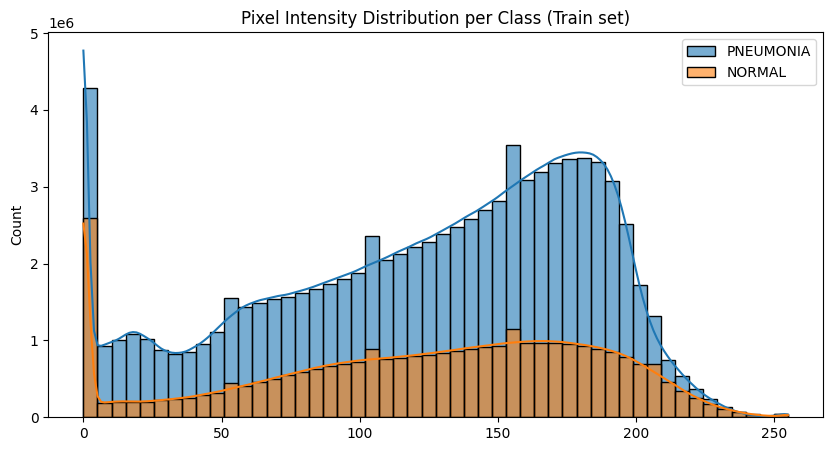

In [44]:
plt.figure(figsize=(10,5))
for i, lab in enumerate(labels):
    pixels = x_train[y_train==i].ravel()
    sns.histplot(pixels, bins=50, kde=True, label=lab, alpha=0.6)
plt.legend()
plt.title("Pixel Intensity Distribution per Class (Train set)")
plt.show()

Tổng số ảnh: 5856
Top 5 kích thước ảnh phổ biến: [((1072, 648), 7), ((1008, 704), 7), ((1080, 728), 6), ((992, 608), 6), ((1216, 872), 6)]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


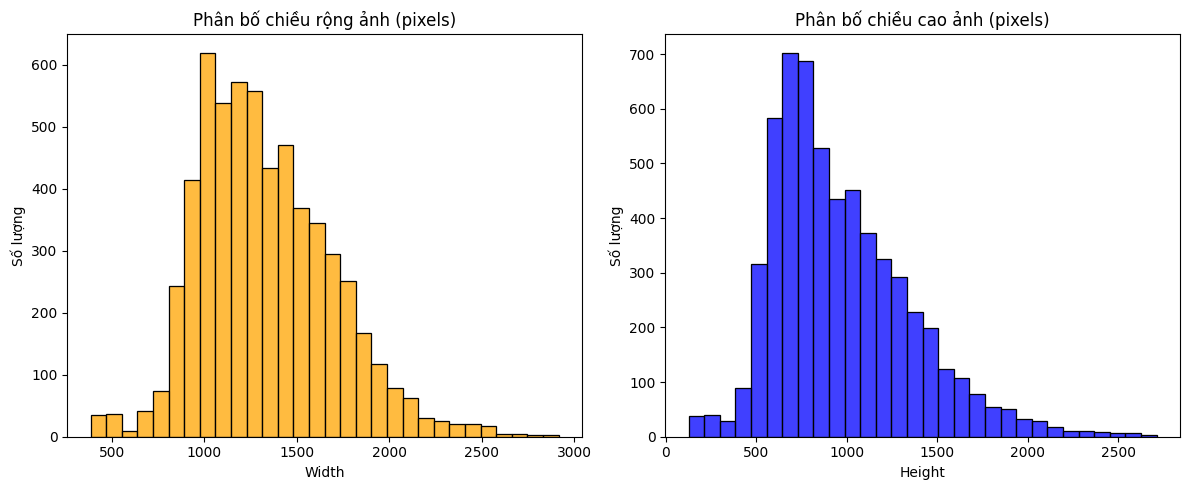

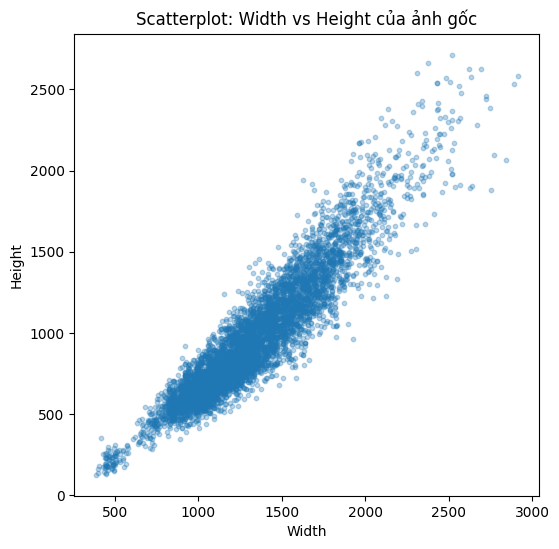

In [46]:
from collections import Counter

def analyze_image_sizes(data_dir):
    sizes = []
    for label in labels:
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:
                    h, w = img_arr.shape
                    sizes.append((w, h))
            except:
                continue
    return sizes

# Lấy toàn bộ size ảnh trong Train/Test/Val
train_sizes = analyze_image_sizes(train_dir)
val_sizes   = analyze_image_sizes(val_dir)
test_sizes  = analyze_image_sizes(test_dir)

all_sizes = train_sizes + val_sizes + test_sizes
print("Tổng số ảnh:", len(all_sizes))

# Đếm các size phổ biến nhất
counter = Counter(all_sizes)
print("Top 5 kích thước ảnh phổ biến:", counter.most_common(5))

# Vẽ phân bố width/height
widths = [w for (w,h) in all_sizes]
heights = [h for (w,h) in all_sizes]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(widths, bins=30, kde=False, color="orange")
plt.title("Phân bố chiều rộng ảnh (pixels)")
plt.xlabel("Width")
plt.ylabel("Số lượng")

plt.subplot(1,2,2)
sns.histplot(heights, bins=30, kde=False, color="blue")
plt.title("Phân bố chiều cao ảnh (pixels)")
plt.xlabel("Height")
plt.ylabel("Số lượng")

plt.tight_layout()
plt.show()

# Vẽ scatter width vs height
plt.figure(figsize=(6,6))
plt.scatter(widths, heights, alpha=0.3, s=10)
plt.title("Scatterplot: Width vs Height của ảnh gốc")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


# **Image Normalization**

In [24]:
# Convert sang numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [25]:
# Normalize the data
x_train = x_train / 255.0
x_val   = x_val / 255.0
x_test  = x_test / 255.0

In [26]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_val   = x_val.reshape(-1, img_size, img_size, 1)
x_test  = x_test.reshape(-1, img_size, img_size, 1)

# **Data Augmentation**

In [37]:
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


data_generator.fit(x_train)